# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][MS][ML][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

pd.options.display.max_colwidth = 100

In [2]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [3]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [4]:
def mse(y_true:np.ndarray, y_predicted:np.ndarray):
    return np.mean((y_true - y_predicted)**2)

def r2(y_true:np.ndarray, y_predicted:np.ndarray):
    res = np.sum((y_true - y_predicted)**2)
    tot = np.sum(((y_true - np.mean(y_true))**2))
    return 1 - res/tot

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [5]:
class NormalLR:
    def __init__(self, fit_intercept=True):
        self.w = None
        self.fit_intercept = fit_intercept

    def fit(self, X: np.ndarray, y: np.ndarray):
        if self.fit_intercept:
            bias = np.ones(X.shape[0])
            X = np.column_stack((bias, X))
        self.w = np.linalg.inv(X.T @ X) @ X.T @ y
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.fit_intercept:
            bias = np.ones(X.shape[0])
            X = np.column_stack((bias, X))
        return X @ self.w.T

In [6]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [7]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.008581141287879922, R2: 0.9985300853435166


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [8]:
class GradientLR:
    def __init__(self, alpha: float, iterations: int = 10000, l: float = 0., fit_intercept: bool = True):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.fit_intercept = fit_intercept
        self.w = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        n_points = X.shape[0]
        if self.fit_intercept:
            bias = np.ones(n_points)
            X = np.column_stack((bias, X))
        n_features = X.shape[1]
        self.w = np.ones(n_features)

        for it in range(self.iterations):
            grad = (1 / n_points) * X.T @ (X @ self.w - y) + self.l * np.sign(self.w)
            self.w -= self.alpha * grad

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.fit_intercept:
            bias = np.ones(X.shape[0])
            X = np.column_stack((bias, X))
        return X @ self.w.T

In [9]:
def build_plot(X_train, y_train, X_test, y_test):
    xs = np.arange(0.0, 0.002, 0.00002)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

In [10]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

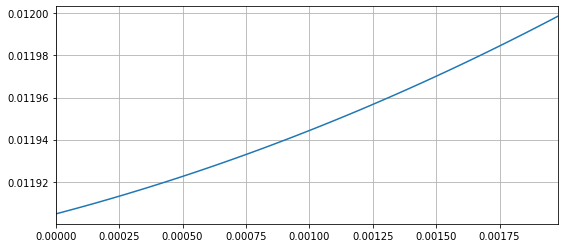

In [11]:
build_plot(X_train, y_train, X_val, y_val)

In [12]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.009280054874589433, R2: 0.9992633355694024


### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [13]:
X, y = read_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=False)

In [14]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 22266311.08083805, R2: 0.687279747566089


In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

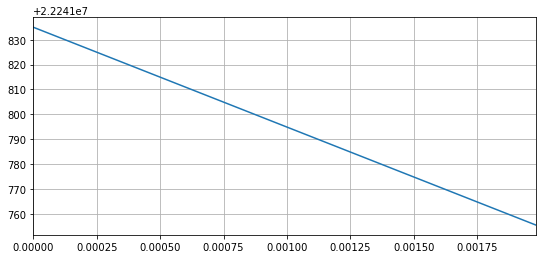

In [16]:
build_plot(X_train_scaled, y_train, X_val_scaled, y_val)

In [17]:
regr = GradientLR(0.1, iterations=10000, l=0.05)
regr.fit(X_train_scaled, y_train)
y_pred = regr.predict(X_val_scaled)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 22239829.698305607, R2: 0.6876516665876224


### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

In [18]:
model = GradientLR(0.1, iterations=10000, l=0.05) # NormalLR()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_val_scaled)

In [19]:
names = ["bias", "crim", "zn", "indus", "chas", "nox", "rm", "age", "dis", "rad", "tax", "ptratio", "b", "lstat", "medv"]

descriptions = [
    "bias from linreg",
    "per capita crime rate by town",
    "proportion of residential land zoned for lots over 25,000 sq.ft",
    "proportion of non-retail business acres per town",
    "Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)",
    "nitric oxides concentration (parts per 10 million)",
    "average number of rooms per dwelling",
    "proportion of owner-occupied units built prior to 1940",
    "weighted distances to five Boston employment centres",
    "index of accessibility to radial highways",
    "full-value property-tax rate per $10,000",
    "pupil-teacher ratio by town",
    "1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town",
    "% lower status of the population",
    "median value of owner-occupied homes in $'s",
]

In [20]:
df_coef = pd.DataFrame.from_dict({
    "name": names[:-1],
    "coef": model.w,
    "desc": descriptions[:-1]
})
df_coef

,name,coef,desc
0,bias,27218.329223,bias from linreg
1,crim,-9134.377961,per capita crime rate by town
2,zn,5192.732572,"proportion of residential land zoned for lots over 25,000 sq.ft"
3,indus,-507.054455,proportion of non-retail business acres per town
4,chas,2321.144210,Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
5,nox,-8303.629757,nitric oxides concentration (parts per 10 million)
6,rm,18992.399536,average number of rooms per dwelling
7,age,1018.437393,proportion of owner-occupied units built prior to 1940
8,dis,-16717.700487,weighted distances to five Boston employment centres
9,rad,7501.754646,index of accessibility to radial highways


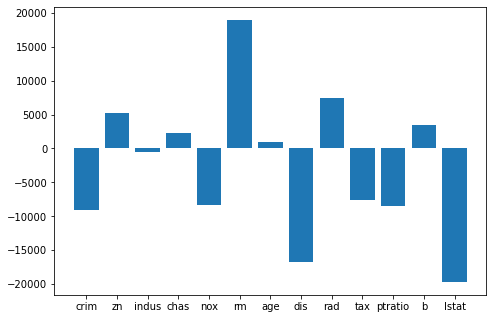

In [21]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(names[1:-1], model.w[1:])
plt.show()

Влияние признаков достаточно логичное.

Признаки, которые повышают комфорт проживания, положительно влияют на таргет. Негативные признаки --- отрицательно.

Так как признаки изначально были заскейлены в диапазон [0, 1], то мы можем посмотреть, как они влияют на таргер относительно друг друга.

Видно, что серьезный положительный вклад имеют признаки rm, rad и zn. Действительно, количество комнат, доступность магистралей и величина участка --- важные составляющие, чем они выше --- тем выше стоимость.

Самый большой отрицательный вклад имеют признаки lstat, dis, crim. Конечно, процент бедных соседей, дистанция до центра и уровени криминала отрицательно влияют на стоимость не только по мнению линейной регрессии, но и при оценке экспертом.

Остальные признаки имеют меньший вклад, для какого-то более подробного анализа необходимо проверить гипотезы о равенстве коэффициентов нулю. Но все равно видно, как, например, загрязненность воздуха и высокая налоговая ставка отрицательно влияют на стоимость.